In [119]:
#Using APRBS with a 90 degree peak to peak

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import math
from simulation_tools import PRBS
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
df = pd.read_csv('aprbs_90ptp_log.txt')
df = df.drop(['timestamp'], axis=1)
#Centre positions at 0
df[['rot_command', 'flex_command', 'rot_cur_pos', 
    'flex_cur_pos','rot_next_pos', 'flex_next_pos']] = df[['rot_command', 'flex_command', 
                                                           'rot_cur_pos', 'flex_cur_pos', 
                                                           'rot_next_pos', 'flex_next_pos']] - 2048

#Centre velocities at 0
df[['rot_cur_vel', 'flex_cur_vel', 
    'rot_next_vel', 'flex_next_vel']] = df[['rot_cur_vel', 'flex_cur_vel', 'rot_next_vel', 'flex_next_vel']] - 1024
#Convert to radians
df = df * 2 * math.pi/4096
df.head()

,rot_command,flex_command,rot_cur_pos,flex_cur_pos,rot_next_pos,flex_next_pos,rot_cur_vel,flex_cur_vel,rot_next_vel,flex_next_vel
0,-3.141593,-3.141593,-0.003068,-0.015340,-0.003068,-0.015340,-1.570796,-1.570796,-1.570796,-1.570796
1,-0.622796,-0.622796,-0.003068,-0.015340,-0.003068,-0.015340,-1.570796,-1.570796,-1.570796,-1.570796
2,-0.622796,-0.622796,-0.003068,-0.015340,-0.012272,-0.023010,-1.570796,-1.570796,0.061359,0.061359
3,-0.622796,-0.622796,-0.012272,-0.023010,-0.030680,-0.039884,0.061359,0.061359,0.141126,0.134990
4,-0.622796,-0.622796,-0.030680,-0.039884,-0.055223,-0.062893,0.141126,0.134990,0.239301,0.227029


In [3]:
X = df[['rot_command', 'flex_command', 'rot_cur_pos', 'flex_cur_pos', 'rot_cur_vel', 'flex_cur_vel']]
y = df[['rot_next_pos', 'flex_next_pos', 'rot_next_vel', 'flex_next_vel']]

In [4]:
X.head()

,rot_command,flex_command,rot_cur_pos,flex_cur_pos,rot_cur_vel,flex_cur_vel
0,-3.141593,-3.141593,-0.003068,-0.015340,-1.570796,-1.570796
1,-0.622796,-0.622796,-0.003068,-0.015340,-1.570796,-1.570796
2,-0.622796,-0.622796,-0.003068,-0.015340,-1.570796,-1.570796
3,-0.622796,-0.622796,-0.012272,-0.023010,0.061359,0.061359
4,-0.622796,-0.622796,-0.030680,-0.039884,0.141126,0.134990


In [5]:
y.head()

,rot_next_pos,flex_next_pos,rot_next_vel,flex_next_vel
0,-0.003068,-0.015340,-1.570796,-1.570796
1,-0.003068,-0.015340,-1.570796,-1.570796
2,-0.012272,-0.023010,0.061359,0.061359
3,-0.030680,-0.039884,0.141126,0.134990
4,-0.055223,-0.062893,0.239301,0.227029


In [45]:
X_train = X[:8000]
X_test = X[8000:].reset_index(drop=True)
y_train = y[:8000]
y_test = y[8000:].reset_index(drop=True)

# LSTM

In [82]:
seq_len = 100
lstm = Sequential()
lstm.add(LSTM(16, batch_input_shape=(1, seq_len, 2), return_sequences=True, stateful=True))
lstm.add(Dense(2))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
lstm.compile(opt, loss='mse')
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (1, 100, 16)              1216      
_________________________________________________________________
dense_13 (Dense)             (1, 100, 2)               34        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


In [100]:
def run_lstm(X, y=None):
    rot_positions = []
    flex_positions = []

    batches = len(X)//seq_len

    mse = 0
    for i in range(batches):
        lstm_input = np.array(X[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, 2)
        model_output = lstm.predict(lstm_input, batch_size=1)

        if y is not None:
            lstm_labels = np.array(y[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, 2)
            mse += mean_squared_error(lstm_labels[0], model_output[0])
        rot_positions.extend(model_output[0][:, 0])
        flex_positions.extend(model_output[0][:, 1])

    if y is not None:
        mse /= batches
        print("MSE:",mse)
    return rot_positions, flex_positions
    

In [83]:
X_train_lstm = X_train[['rot_command', 'flex_command']]
y_train_lstm = y_train[['rot_next_pos', 'flex_next_pos']]
X_test_lstm = X_test[['rot_command', 'flex_command']]
y_test_lstm = y_test[['rot_next_pos', 'flex_next_pos']]

In [84]:
batches = len(X_train_lstm)//seq_len
epochs = 50

In [85]:
for _ in range(epochs):
    err = 0
    for i in range(batches):
        lstm_input = np.array(X_train_lstm[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, 2)
        lstm_labels = np.array(y_train_lstm[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, 2)
        hist = lstm.fit(lstm_input, lstm_labels, batch_size=1, verbose=0)
        err += hist.history['loss'][0]
    err /= batches
    print(err, ',', end='')

0.057276761680986964 ,0.007937624604710435 ,0.0073545997369365065 ,0.006820843742116267 ,0.006291784390305111 ,0.006007862041951739 ,0.005893090778954502 ,0.0058390624902813215 ,0.0057899568485481724 ,0.005729675361089903 ,0.005659168778311141 ,0.005581181233242205 ,0.005495432694647207 ,0.005402760265724282 ,0.005298173090793057 ,0.005172826481214798 ,0.005008297310774878 ,0.0047666167516581485 ,0.004423164684794756 ,0.00409354367893684 ,0.0038288435732283686 ,0.0036280075059494264 ,0.0034782123600507475 ,0.0033563489951120573 ,0.003250631619266642 ,0.0031565927316478336 ,0.0030714129147327183 ,0.002993275565404474 ,0.002921175474102711 ,0.0028546614692459117 ,0.002793613531912342 ,0.0027380603999972663 ,0.002688050875940462 ,0.0026435689826030282 ,0.0026044743943884896 ,0.002570492892505172 ,0.0025412171675156968 ,0.0025161380081272 ,0.002494683726979474 ,0.0024762660187207077 ,0.0024603187791853998 ,0.0024463312445050177 ,0.0024338619485547498 ,0.0024225535821528867 ,0.0024121169397

### Testing on test set

MSE: 0.009084183532044926


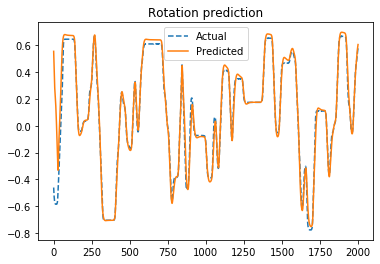

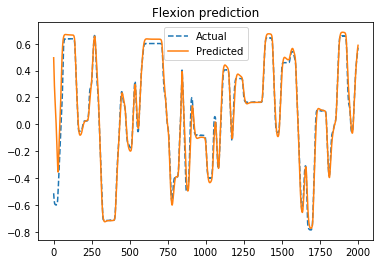

In [101]:
rot_positions, flex_positions = run_lstm(X_test_lstm, y_test_lstm)

plt.plot(y_test['rot_next_pos'], '--')
plt.plot(rot_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(y_test['flex_next_pos'], '--')
plt.plot(flex_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

### Testing on a step input

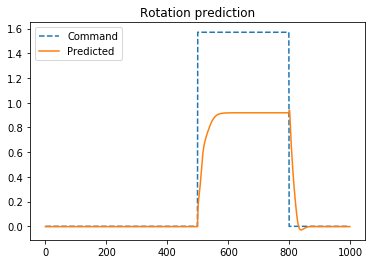

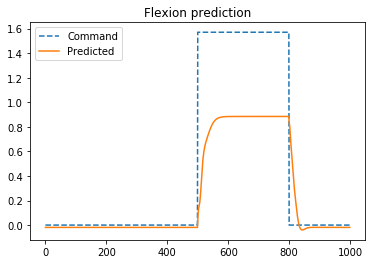

In [112]:
#You can see that it doens't generlize well to 90 degrees since the APRBS was only to 45
step = np.zeros((1000, 2))
step[500:800, 0] = math.pi/2
step[500:800, 1] = math.pi/2

rot_positions, flex_positions = run_lstm(step)

plt.plot(step[:, 0], '--')
plt.plot(rot_positions)
plt.legend(['Command', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(step[:, 1], '--')
plt.plot(flex_positions)
plt.legend(['Command', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

# Neural Network

In [116]:
nn = Sequential()
nn.add(Dense(8, input_shape=(6,), activation='relu'))
nn.add(Dense(4))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
nn.compile(opt, loss='mse')
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 8)                 56        
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 36        
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [117]:
nn.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
8000/8000 [==============================] - 1s 137us/step - loss: 0.6438
Epoch 2/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.1106
Epoch 3/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.0607
Epoch 4/100
8000/8000 [==============================] - ETA: 0s - loss: 0.048 - 0s 24us/step - loss: 0.0467
Epoch 5/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.0386
Epoch 6/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.0330
Epoch 7/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.0292
Epoch 8/100
8000/8000 [==============================] - 0s 25us/step - loss: 0.0270
Epoch 9/100
8000/8000 [==============================] - 0s 23us/step - loss: 0.0258
Epoch 10/100
8000/8000 [==============================] - 0s 25us/step - loss: 0.0251
Epoch 11/100
8000/8000 [==============================] - 0s 27us/step - loss: 0.0247
Epoch 12/100
8000/8000 [==============

### Testing on test set

MSE: 0.4877646341271577


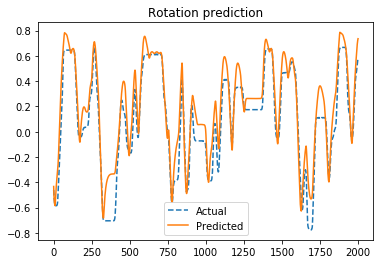

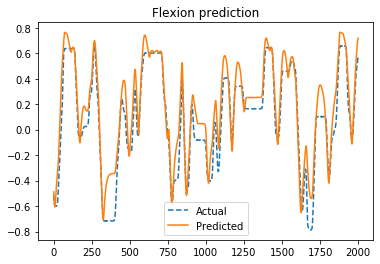

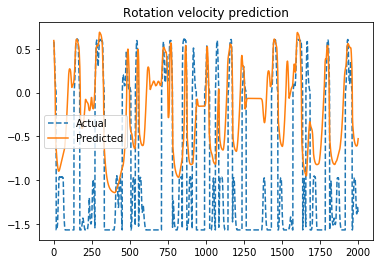

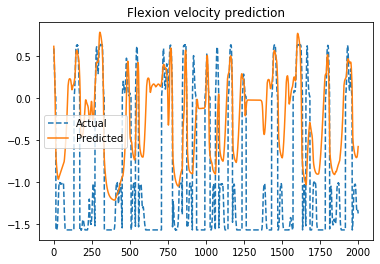

In [118]:
rot_positions = np.zeros(len(X_test))
flex_positions = np.zeros(len(X_test))
rot_velocities = np.zeros(len(X_test))
flex_velocities = np.zeros(len(X_test))

rot_cur_pos = X_test['rot_cur_pos'].iloc[0]
flex_cur_pos = X_test['flex_cur_pos'].iloc[0]
rot_cur_vel = X_test['rot_cur_vel'].iloc[0]
flex_cur_vel = X_test['flex_cur_vel'].iloc[0]
mse = 0
for i in range(len(X_test)):
    rot_positions[i] = rot_cur_pos
    flex_positions[i] = flex_cur_pos
    rot_velocities[i] = rot_cur_vel
    flex_velocities[i] = flex_cur_vel

    rot_command = X_test['rot_command'].iloc[i]
    flex_command = X_test['flex_command'].iloc[i]

    model_input = np.array([[rot_command, flex_command, rot_cur_pos, flex_cur_pos, rot_cur_vel, flex_cur_vel]])
    model_output = nn.predict(model_input, batch_size=1)[0]
    rot_cur_pos = model_output[0]
    flex_cur_pos = model_output[1]
    rot_cur_vel = model_output[2]
    flex_cur_vel = model_output[3]
    
    mse += mean_squared_error(y_test.iloc[i], model_output)
mse /= len(X_test)
print("MSE:",mse)

plt.plot(y_test['rot_next_pos'], '--')
plt.plot(rot_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(y_test['flex_next_pos'], '--')
plt.plot(flex_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

plt.plot(y_test['rot_next_vel'], '--')
plt.plot(rot_velocities)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation velocity prediction")
plt.show()

plt.plot(y_test['flex_next_vel'], '--')
plt.plot(flex_velocities)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion velocity prediction")
plt.show()
